In [19]:
%load_ext autoreload
%autoreload 2

import os
import sys

# Ruta absoluta al directorio principal del proyecto
proyecto_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Agregar la ruta al sistema
if proyecto_path not in sys.path:
    sys.path.append(proyecto_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from rich import print

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import ElasticNet

from src.evaluate import regression_metrics
from src.training import (
    optimize_hyperparameters,
    objective_random_forest,
    objective_lightgbm,
    objective_xgboost,
    objective_elastic_net
) 

import pandas as pd
import warnings
import pickle
import json
warnings.filterwarnings('ignore')


In [21]:
# Config With Feature names
with open('../src/config.json', 'r') as f:
    config_dict = json.load(f)

y_column = config_dict['y_column']
numeric_features = config_dict['numeric_features']
categorical_features = config_dict['categorical_features']
all_features = numeric_features + categorical_features

# Processed Data
with open('../data/processed/ml_data.pkl', 'rb') as f:
    data_dict = pickle.load(f)

X_train = data_dict['X_train']
X_test = data_dict['X_test']
y_train = data_dict['y_train']
y_test = data_dict['y_test']
feature_names = data_dict['feature_names']
X_preprocessor = data_dict['X_preprocessor']
y_preprocessor = data_dict['y_preprocessor']

In [22]:
X_train

array([[-0.66862534, -0.66862534, -0.35708416, ...,  0.        ,
         0.        ,  1.        ],
       [-0.72347218, -0.72347218, -0.1641197 , ...,  0.        ,
         0.        ,  1.        ],
       [-1.03884154, -1.03884154, -0.35708416, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.84061781,  1.84061781, -0.35708416, ...,  0.        ,
         0.        ,  1.        ],
       [-0.66862534, -0.66862534, -0.14574214, ...,  0.        ,
         0.        ,  1.        ],
       [-0.97028298, -0.97028298, -0.35708416, ...,  1.        ,
         0.        ,  1.        ]], shape=(8512, 19))

In [23]:
X_test

array([[-0.81945416, -0.81945416, -0.19628045, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47666138, -0.47666138, -0.09060943, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.59285209,  0.59285209,  0.27694191, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.57914038,  0.57914038,  0.27234752, ...,  0.        ,
         0.        ,  1.        ],
       [-0.88801272, -0.88801272, -0.21006362, ...,  0.        ,
         1.        ,  0.        ],
       [-0.47666138, -0.47666138, -0.35708416, ...,  0.        ,
         1.        ,  0.        ]], shape=(2129, 19))

In [24]:
y_train

array([[-0.08031837],
       [-0.11944609],
       [-0.68001258],
       ...,
       [ 5.19933758],
       [-0.9127741 ],
       [-0.40880512]], shape=(8512, 1))

### Entrenamiento

In [25]:
train_metrics_list = []
test_metrics_list = []

print('Tunning Random Forest')
best_params = optimize_hyperparameters(objective_random_forest, X_train, y_train.ravel())

model = RandomForestRegressor(**best_params)
model.fit(X_train, y_train)

y_train_raw = model.predict(X_train)
y_test_raw = model.predict(X_test)

y_train_orig = y_preprocessor.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred = y_preprocessor.inverse_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_pred = y_preprocessor.inverse_transform(y_test_raw.reshape(-1, 1)).flatten()

train_metrics = regression_metrics(y_train_orig, y_train_pred, title = 'Training') | {'model': 'random_forest'}
test_metrics = regression_metrics(y_test, y_test_pred, title = 'Test') | {'model': 'random_forest'}
train_metrics_list.append(train_metrics)
test_metrics_list.append(test_metrics)

with open('../models/random_forest_optuna.pkl', 'wb') as f:
    pickle.dump(model, f)


Tunning Random Forest

  0%|          | 0/50 [00:00<?, ?it/s]

Best trial: 7. Best value: 0.371562: 100%|██████████| 50/50 [05:52<00:00,  7.06s/it]


Training
MAPE: 14.2 % 
MDAPE: 7.7 % 
R2: 88.4 % 
explained_variance_score: 88.8 % 


MAE: 624,016.04 
RMSE: 1,297,255.76 


Mean Residual: -255,198.4791
Std Residual: 1,271,906.5390
Max Error: 10,700,000.0000
Test
MAPE: 28.1 % 
MDAPE: 15.2 % 
R2: 76.3 % 
explained_variance_score: 76.7 % 


MAE: 1,131,074.39 
RMSE: 1,998,275.51 


Mean Residual: -267,182.0362
Std Residual: 1,980,332.9942
Max Error: 11,505,502.7867


In [26]:
print('Tunning XGBoost')
best_params = optimize_hyperparameters(objective_xgboost, X_train, y_train.ravel())
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

y_train_raw = model.predict(X_train)
y_test_raw = model.predict(X_test)

y_train_orig = y_preprocessor.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred = y_preprocessor.inverse_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_pred = y_preprocessor.inverse_transform(y_test_raw.reshape(-1, 1)).flatten()

train_metrics = regression_metrics(y_train_orig, y_train_pred, title = 'Training') | {'model': 'xgboost'}
test_metrics = regression_metrics(y_test, y_test_pred, title = 'Test') | {'model': 'xgboost'}
train_metrics_list.append(train_metrics)
test_metrics_list.append(test_metrics)

train_metrics_list
with open('../models/xgboost_optuna.pkl', 'wb') as f:
    pickle.dump(model, f)


Tunning XGBoost

Best trial: 41. Best value: 0.379923: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]


Training
MAPE: 18.3 % 
MDAPE: 12.8 % 
R2: 88.3 % 
explained_variance_score: 88.4 % 


MAE: 749,662.59 
RMSE: 1,303,875.66 


Mean Residual: -108,330.1424
Std Residual: 1,299,367.6623
Max Error: 8,685,010.0000
Test
MAPE: 27.3 % 
MDAPE: 16.7 % 
R2: 77.0 % 
explained_variance_score: 77.3 % 


MAE: 1,143,684.53 
RMSE: 1,966,607.77 


Mean Residual: -229,357.7360
Std Residual: 1,953,187.4384
Max Error: 11,000,000.0000


In [27]:
print('Tunning LGBM')
best_params = optimize_hyperparameters(objective_lightgbm, X_train, y_train.ravel())
model = LGBMRegressor(verbose=-1, **best_params)
model.fit(X_train, y_train)

y_train_raw = model.predict(X_train)
y_test_raw = model.predict(X_test)

y_train_orig = y_preprocessor.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred = y_preprocessor.inverse_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_pred = y_preprocessor.inverse_transform(y_test_raw.reshape(-1, 1)).flatten()

train_metrics = regression_metrics(y_train_orig, y_train_pred, title = 'Training') | {'model': 'lgbm'}
test_metrics = regression_metrics(y_test, y_test_pred, title = 'Test') | {'model': 'lgbm'}
train_metrics_list.append(train_metrics)
test_metrics_list.append(test_metrics)

with open('../models/lgbm_optuna.pkl', 'wb') as f:
    pickle.dump(model, f)


Tunning LGBM

Best trial: 34. Best value: 0.365359: 100%|██████████| 50/50 [01:47<00:00,  2.16s/it]


Training
MAPE: 15.2 % 
MDAPE: 10.3 % 
R2: 90.6 % 
explained_variance_score: 90.7 % 


MAE: 640,116.38 
RMSE: 1,167,714.29 


Mean Residual: -114,964.0566
Std Residual: 1,162,041.2788
Max Error: 8,588,128.8240
Test
MAPE: 26.4 % 
MDAPE: 15.6 % 
R2: 76.3 % 
explained_variance_score: 76.5 % 


MAE: 1,135,505.84 
RMSE: 1,998,774.27 


Mean Residual: -208,358.0996
Std Residual: 1,987,884.6727
Max Error: 10,711,254.9500


In [28]:
print('Tunning Elastic Net')
best_params = optimize_hyperparameters(objective_elastic_net, X_train, y_train.ravel())
model = ElasticNet(**best_params)
model.fit(X_train, y_train)

y_train_raw = model.predict(X_train)
y_test_raw = model.predict(X_test)

y_train_orig = y_preprocessor.inverse_transform(y_train.reshape(-1, 1)).flatten()
y_train_pred = y_preprocessor.inverse_transform(y_train_raw.reshape(-1, 1)).flatten()
y_test_pred = y_preprocessor.inverse_transform(y_test_raw.reshape(-1, 1)).flatten()

train_metrics = regression_metrics(y_train_orig, y_train_pred, title = 'Training') | {'model': 'elastic_net'}
test_metrics = regression_metrics(y_test, y_test_pred, title = 'Test') | {'model': 'elastic_net'}
train_metrics_list.append(train_metrics)
test_metrics_list.append(test_metrics)

with open('../models/elastic_net_optuna.pkl', 'wb') as f:
    pickle.dump(model, f)

Tunning Elastic Net

Best trial: 44. Best value: 0.581318: 100%|██████████| 50/50 [00:02<00:00, 23.01it/s]


Training
MAPE: 38.3 % 
MDAPE: 25.6 % 
R2: 58.5 % 
explained_variance_score: 58.6 % 


MAE: 1,459,458.18 
RMSE: 2,452,537.27 


Mean Residual: -101,717.6225
Std Residual: 2,450,427.0221
Max Error: 12,649,825.0810
Test
MAPE: 39.6 % 
MDAPE: 26.4 % 
R2: 60.2 % 
explained_variance_score: 60.2 % 


MAE: 1,596,899.73 
RMSE: 2,589,071.70 


Mean Residual: -16,298.4836
Std Residual: 2,589,020.4022
Max Error: 14,500,000.0000


In [29]:
train_metrics_df = pd.DataFrame(train_metrics_list)
train_metrics_df['Set'] = 'Training'

test_metrics_df = pd.DataFrame(test_metrics_list)
test_metrics_df['Set'] = 'Test'

metrics_df = pd.concat([train_metrics_df, test_metrics_df])
metrics_df

,MAPE,MDAPE,R2,explained_variance_score,MAE,RMSE,Mean Residual,Std Residual,Max Error,model,Set
0,0.142391,0.076923,0.883989,0.888479,6.240160e+05,1.297256e+06,-255198.479138,1.271907e+06,1.070000e+07,random_forest,Training
1,0.183368,0.127658,0.882802,0.883611,7.496626e+05,1.303876e+06,-108330.142357,1.299368e+06,8.685010e+06,xgboost,Training
2,0.152079,0.102540,0.906002,0.906913,6.401164e+05,1.167714e+06,-114964.056633,1.162041e+06,8.588129e+06,lgbm,Training
3,0.383297,0.255530,0.585354,0.586067,1.459458e+06,2.452537e+06,-101717.622476,2.450427e+06,1.264983e+07,elastic_net,Training
0,0.281477,0.151515,0.762770,0.767011,1.131074e+06,1.998276e+06,-267182.036159,1.980333e+06,1.150550e+07,random_forest,Test
1,0.272558,0.166666,0.770229,0.773355,1.143685e+06,1.966608e+06,-229357.736026,1.953187e+06,1.100000e+07,xgboost,Test
2,0.264401,0.155556,0.762651,0.765231,1.135506e+06,1.998774e+06,-208358.099618,1.987885e+06,1.071125e+07,lgbm,Test
3,0.396090,0.263894,0.601758,0.601773,1.596900e+06,2.589072e+06,-16298.483572,2.589020e+06,1.450000e+07,elastic_net,Test


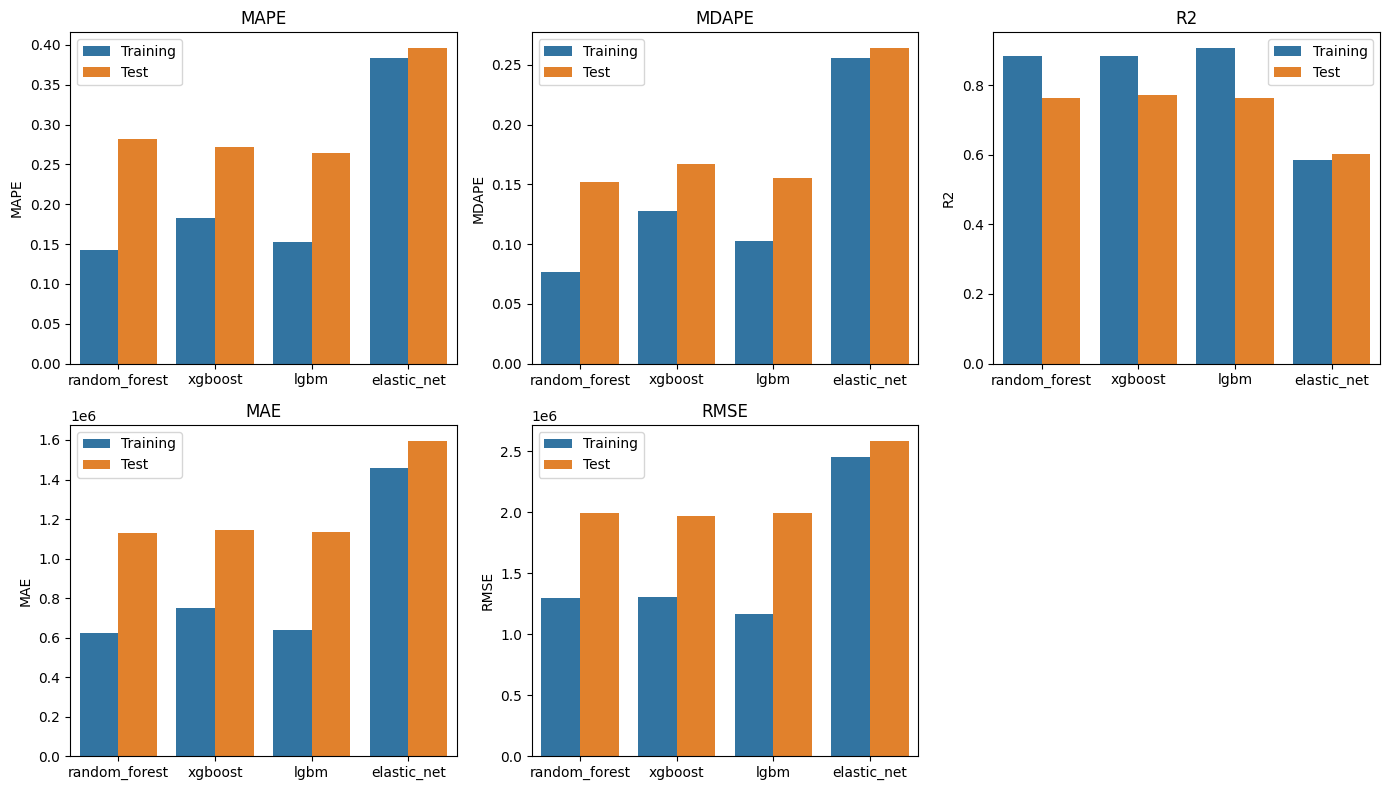

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 8))
metrics_to_plot = ['MAPE', 'MDAPE', 'R2', 'MAE', 'RMSE']
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.barplot(
        data=metrics_df,
        x='model',
        y=metric,
        hue='Set'
    )
    plt.title(metric)
    plt.xlabel('')
    plt.ylabel(metric)
    plt.legend(loc='best')
plt.tight_layout()
plt.show()
